Arquitectura

https://medium.com/x8-the-ai-community/audio-classification-using-cnn-coding-example-f9cbd272269e

In [4]:
import sys
sys.executable

'/home/julian/anaconda3/envs/py3/bin/python3'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13812836280057564137
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11604808423491385038
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15145224286950440135
physical_device_desc: "device: XLA_GPU device"
]


In [6]:
! python -c 'import tensorflow as tf; print(tf.__version__)'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'tensorflow'


In [7]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D,Dropout,Flatten,MaxPooling2D, Input
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix

In [8]:
path = '../../data/spectrograms/spectrograms_15000.hd5'

In [9]:
df = pd.read_hdf(path)

FileNotFoundError: File ../../data/spectrograms/spectrograms_15000.hd5 does not exist

In [10]:
test_size = 0.2

### Reshape images add channel

In [11]:
width=df.Spectrogram[0].shape[1]
high=df.Spectrogram[0].shape[0]
images_number = len(df)

In [12]:
images_dimensions =(1,high,width)
images_dimensions

(1, 99, 161)

In [13]:
x_shape = (images_number,high,width) 

In [14]:
d = np.zeros(x_shape)
cont_images = 0
for i in df['Spectrogram'].values:
    i.reshape(images_dimensions)
    d[cont_images,:,:]=i
    cont_images =cont_images +1

In [15]:
d.shape ## matriz con las imagenes 

(5000, 99, 161)

# Dataset

In [16]:
X = d
Y = df.word.values
print('Tamaño dataSet', X.shape)
print('\n')
Y = np.reshape(Y,(np.size(Y,0),1))
print('Y shape',Y.shape)
groups = df.speaker.values

Tamaño dataSet (5000, 99, 161)


Y shape (5000, 1)


## Data Split

In [17]:
def splitDataSet(X,Y,groups,test_size):              
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
        gss.get_n_splits()
        returns = []
        for train_index, test_index in gss.split(X, Y, groups=groups):
            X_train_original, X_test_original = X[train_index], X[test_index]
            Y_train__original, Y_test_original = Y[train_index], Y[test_index]
            groups_original = groups[train_index]
            groups_test_original=groups[test_index]
            returns.append(X_train_original)
            returns.append(Y_train__original)
            returns.append(X_test_original)
            returns.append(Y_test_original)
            returns.append(groups_original)
            returns.append(groups_test_original) 
              
        return returns

In [18]:
data_train = splitDataSet(X,Y,groups,test_size)
X_train_original = data_train[0]
Y_train__original=data_train[1]
X_test_original=data_train[2]
Y_test_original=data_train[3]
groups_original=data_train[4]
groups_test_original=data_train[5]

In [19]:
X_train_original.shape

(4111, 99, 161)

In [20]:
Y_test_original.shape

(889, 1)

# Expandir dimensiones de X 

In [21]:
X_train_original= np.expand_dims(X_train_original, axis=3)
X_test_original= np.expand_dims(X_test_original, axis=3)

In [22]:
X_train_original.shape

(4111, 99, 161, 1)

In [23]:
X_test_original.shape

(889, 99, 161, 1)

# One-hot

In [24]:
y_trainOHE = utils.to_categorical(Y_train__original)
y_trainOHE

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [25]:
### Número de clases
num_classes = y_trainOHE.shape[1]

In [26]:
input_shape =(high,width,1)

In [27]:
input_shape

(99, 161, 1)

In [28]:
num_classes

5

## Define the network architecture using keras

In [29]:
model = Sequential()

img= Input(shape=input_shape)

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

validity = model(img)

Model(img, validity)

# loss function and optimizer

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 97, 159, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 95, 157, 64)       18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 78, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 78, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 234624)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               30032000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

# Training

In [ ]:
print("Training...")
history = model.fit(X_train_original, y_trainOHE, epochs=10, batch_size=100, validation_split=0.1, verbose=1)

Training...
Train on 3699 samples, validate on 412 samples
Epoch 1/10
3699/3699 [==============================] - 126s 34ms/sample - loss: 8.8763 - accuracy: 0.3036 - val_loss: 1.8245 - val_accuracy: 0.0000e+00
Epoch 2/10
3699/3699 [==============================] - 125s 34ms/sample - loss: 1.6058 - accuracy: 0.2509 - val_loss: 1.6850 - val_accuracy: 0.0000e+00
Epoch 3/10
3699/3699 [==============================] - 127s 34ms/sample - loss: 1.5980 - accuracy: 0.2220 - val_loss: 1.7940 - val_accuracy: 0.0000e+00
Epoch 4/10
3699/3699 [==============================] - 130s 35ms/sample - loss: 1.5911 - accuracy: 0.2244 - val_loss: 1.8803 - val_accuracy: 0.0000e+00
Epoch 5/10
3699/3699 [==============================] - 126s 34ms/sample - loss: 1.5869 - accuracy: 0.2214 - val_loss: 1.9611 - val_accuracy: 0.0000e+00
Epoch 6/10
3699/3699 [==============================] - 127s 34ms/sample - loss: 1.5827 - accuracy: 0.2271 - val_loss: 2.0257 - val_accuracy: 0.0000e+00
Epoch 7/10
3699/3699 [=

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


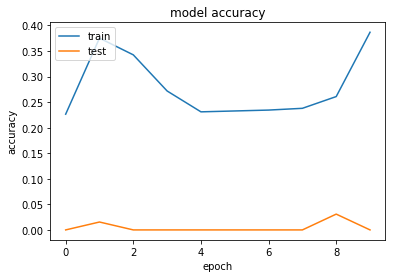

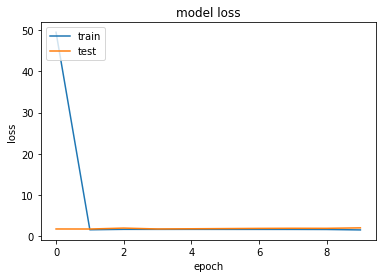

In [28]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict

In [29]:
def predict(model,X_test_original):
    Yest = model.predict(X_test_original)
    Yest = np.argmax(Yest, axis=1)
    Yest = Yest.reshape((Yest.shape[0],1))
    return Yest

In [30]:
def consfusion_matrix(Y_real,preds,nb_classes):
    Accuracy = np.mean(preds == Y_real)
    print('Accuracy = ', Accuracy*100, '% ')
    objects = ('yes','no','right','five','nine')
    cm = confusion_matrix(Y_real, preds)
    cm = cm/np.sum(cm,axis=0)
    cmap = plt.cm.gray
    tick_marks = np.arange(nb_classes)
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, np.around(cm[i, j],decimals=2),
                           ha="center", va="center", color="w")
    plt.title('Normalized confusion matrix')
    fig.colorbar(im)
    plt.xticks(tick_marks, objects, rotation=45)
    plt.yticks(tick_marks, objects);

Accuracy =  21.908127208480565 % 


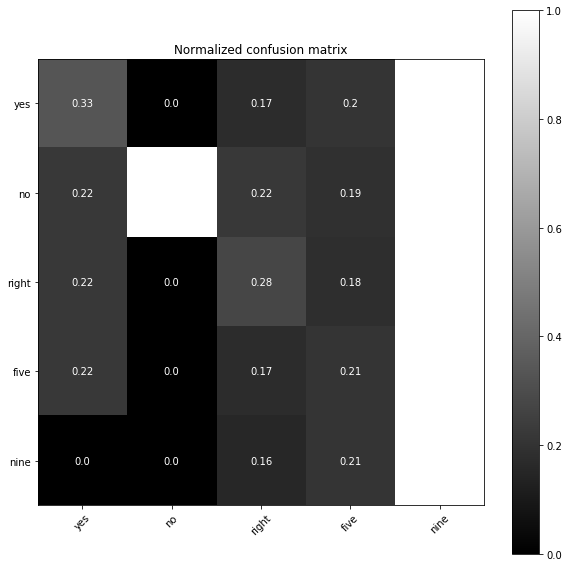

In [31]:
Yest  = predict(model,X_test_original)
Yest =Yest.flatten()
Yest =np.array(Yest)
Y_test_original= Y_test_original.flatten()
Y_test_original =list(Y_test_original)
consfusion_matrix(Y_test_original,Yest,5)

In [ ]:
path_model_Save = '/home/josearangos/Documentos/Projects/Voice_Recognition/pipelines/Enoque_Imagenes_Espectrograma_CNN/models/mode_2500_trained_samples_10_epochs_arquitectura2'

In [ ]:
model.save(path_model_Save)